In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
from nltk.translate.bleu_score import sentence_bleu
import json
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from textblob import TextBlob
import csv
import glob
import time
from PIL import Image
import os
import torch
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
annotation_file = 'annotation.json'
results_file = 'results.json'
nltk.download('wordnet')
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]

D = torch.device
CPU = torch.device('cpu')

def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')

CUDA = get_device

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

is_gpu = False #@param {type:"boolean"}

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

prefix_length = 10

model = ClipCaptionModel(prefix_length)

model_path = "./checkpoints/vizcofk2_mlp-005.pt"

model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False)

model = model.eval()
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

use_beam_search = False #@param {type:"boolean"}


IMAGE_FOLDER = "./testing3"

reference = []
with open("testing3.csv", newline='') as f:
    csvreader = csv.reader(f)
    for row in csvreader:
        reference.append(row[1])
# Define custom sort function that sorts file names based on numeric suffixes
def numeric_sort(file_path):
    prefix, suffix = file_path.split("/")[-1].split(".")[0].split("photo")
    return int(suffix)

# Get list of image file paths
image_paths = sorted(glob.glob(IMAGE_FOLDER + "/*.jpg"), key=numeric_sort)

time_sum = 0
i = 0
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
meteor = []
rougel = []
cider = []
spice = []
subject = []
# Open the CSV file for writing
with open('./csv/clipcap_testing3_vizcofk2_mlp-005.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'Output', 'Time Taken', 'Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE', 'subjectivity'])

    # Loop over each image file path
    for image_path in image_paths:
        start_time = time.time()
        # Open image using PIL
        img = Image.open(image_path)
        image = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            # if type(model) is ClipCaptionE2E:
            #     prefix_embed = model.forward_image(image)
            # else:
            prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        if use_beam_search:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
        else:
            generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


        # Display image and output
        end_time = time.time()
        time_taken = round(end_time - start_time, 2)
        time_sum += time_taken


        display(img)
        print("Reference:", reference[i])
        print("Generated caption:", generated_text_prefix)
        # Extract file name from the path
        file_name = os.path.basename(image_path)
        print("File name:", file_name)
        print("Time taken: {}".format(time_taken))
        
        image_file = 'annotation.jpg'
        # Create a dictionary with information about the image
        image_info = {
            'id': 0,
            'file_name': image_file,
            'width': 640,
            'height': 480
        }

        # Create a list with information about the annotation (only one image, so the image_id is always 0)
        annotation_info = [
            {
                'id': 0,
                'image_id': 0,
                'caption': reference[i],
                'category_id': 0
            }
        ]

        # Create a dictionary with information about the categories
        category_info = [
            {
                'id': 0,
                'name': 'cat'
            }
        ]

        # Create a dictionary with information about the dataset
        annotation_info = {
            'info': {
                'description': 'One image dataset',
                'version': '1.0',
                'year': 2022,
                'contributor': 'Your Name'
            },
            'licenses': [],
            'images': [image_info],
            'annotations': annotation_info,
            'categories': category_info
        }


        with open(annotation_file, 'w') as f:
            json.dump(annotation_info, f)
            results_info = {"image_id": 0, "caption": generated_text_prefix}
        with open(results_file, 'w') as f:
            json.dump([results_info], f)

        # Create a COCO object for the annotations and a COCO object for the predicted captions
        coco = COCO(annotation_file)
        coco_result = coco.loadRes(results_file)

        # Create a COCOEvalCap object using the annotations and predicted captions
        coco_eval = COCOEvalCap(coco, coco_result)

        # Set the image IDs to evaluate (this can be a subset, or all images)
        coco_eval.params['image_id'] = coco_result.getImgIds()

        # Evaluate the results using the COCO evaluation metrics (this can take a few minutes)
        coco_eval.evaluate()
        subjectivity_score = TextBlob(generated_text_prefix).subjectivity
        print("Subjectivity: ", subjectivity_score)
        


        # Write the image details to the CSV file
        print("i: ", i)
        writer.writerow([file_name, generated_text_prefix, time_taken, coco_eval.eval['Bleu_1'], coco_eval.eval['Bleu_2'], coco_eval.eval['Bleu_3'], coco_eval.eval['Bleu_4'], coco_eval.eval['METEOR'], coco_eval.eval['ROUGE_L'], coco_eval.eval['CIDEr'], coco_eval.eval['SPICE'], subjectivity_score])
        
        i += 1
        bleu1.append(coco_eval.eval['Bleu_1'])
        bleu2.append(coco_eval.eval['Bleu_2'])
        bleu3.append(coco_eval.eval['Bleu_3'])
        bleu4.append(coco_eval.eval['Bleu_4'])
        meteor.append(coco_eval.eval['METEOR'])
        rougel.append(coco_eval.eval['ROUGE_L'])
        cider.append(coco_eval.eval['CIDEr'])
        spice.append(coco_eval.eval['SPICE'])

        subject.append(subjectivity_score)
    writer.writerow([f"{sum(bleu1)/50:.6f}", f"{sum(bleu2)/50:.6f}", f"{sum(bleu3)/50:.6f}", f"{sum(bleu4)/50:.6f}", f"{sum(meteor)/50:.6f}", f"{sum(rougel)/50:.6f}", f"{sum(spice)/50:.6f}", f"{sum(subject)/50:.6f}"])
        

print(f"Average time taken:{time_sum/50:.6f}")
print(f"Average Bleu1 score:{sum(bleu1)/50:.6f}")
print(f"Average Bleu2 score:{sum(bleu2)/50:.6f}")
print(f"Average Bleu3 score:{sum(bleu3)/50:.6f}")
print(f"Average Bleu4 score:{sum(bleu4)/50:.6f}")
print(f"Average Meteor score:{sum(meteor)/50:.6f}")
print(f"Average ROUGEL score:{sum(rougel)/50:.6f}")
print(f"Average CIDEr score:{sum(cider)/50:.6f}")
print(f"Average SPICE score:{sum(spice)/50:.6f}")
print(f"Average subjectivity score:{sum(subject)/50:.6f}")


In [ ]:
IMAGE_FOLDER = "./testing2"
model_path = "./checkpoints/vizcofk3_gpt-006.pt"
model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False)

model = model.eval()
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)
# Define custom sort function that sorts file names based on numeric suffixes
def numeric_sort(file_path):
    prefix, suffix = file_path.split("/")[-1].split(".")[0].split("photo")
    return int(suffix)

# Get list of image file paths
image_paths = sorted(glob.glob(IMAGE_FOLDER + "/*.jpg") + glob.glob(IMAGE_FOLDER + "/*.JPG"), key=numeric_sort)

# Define custom sort function that sorts file names based on numeric suffixes
def numeric_sort(file_path):
    prefix, suffix = file_path.split("/")[-1].split(".")[0].split("photo")
    return int(suffix)

# Get list of image file paths
image_paths = sorted(glob.glob(IMAGE_FOLDER + "/*.jpg"), key=numeric_sort)

# Open the CSV file for writing
with open('./csv/CLipCap_testing2_vizcofk3_gpt-006.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File Name', 'Output', 'Time Taken'])

    # Loop over each image file path
    for image_path in image_paths:
        start_time = time.time()
        # Open image using PIL
        image = io.imread(image_path)
        pil_image = PIL.Image.fromarray(image)
        image = preprocess(pil_image).unsqueeze(0).to(device)

        with torch.no_grad():
            # if type(model) is ClipCaptionE2E:
            #     prefix_embed = model.forward_image(image)
            # else:
            prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        if use_beam_search:
            generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
        else:
            try:
                generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
            except TypeError:
                continue

        # Display image and output
        end_time = time.time()
        time_taken = round(end_time - start_time, 2)
        time_sum += time_taken


        display(pil_image)
        print("Generated caption:", generated_text_prefix)
        # Extract file name from the path
        file_name = os.path.basename(image_path)
        print("File name:", file_name)
        print("Time taken: {}".format(time_taken))

        # Write the image details to the CSV file
        writer.writerow([file_name, generated_text_prefix, time_taken])

print("Average time taken:", time_sum/50)

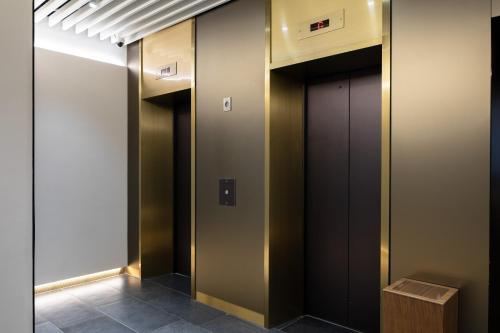

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]



a hallway with a large mirror and a door                                                          


In [14]:
image = io.imread('1.JPG')
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

In [50]:
IMAGE_FOLDER = "./object_test"
model_path = "./checkpoints/vizcofk3_gpt-006.pt"
model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False)

model = model.eval()
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

100%|████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


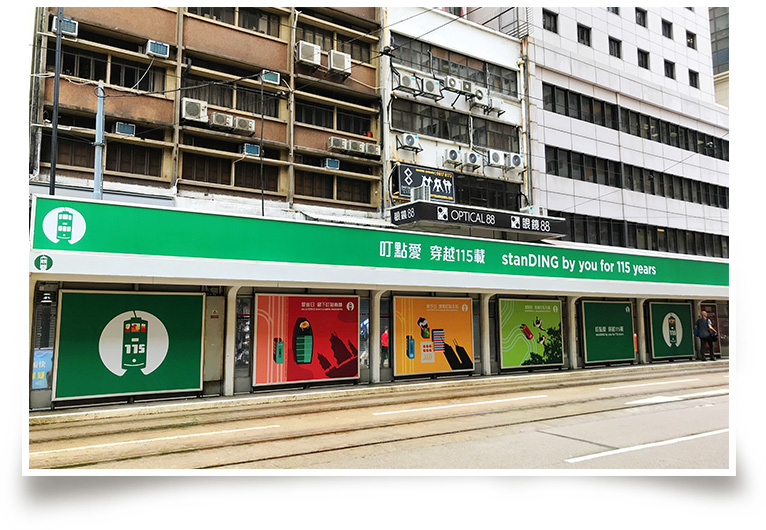

Generated caption: a green minibus stop in front of a store  and a bus stop in the background                                                 
File name: 2019_2_pic.jpg
Time taken: 6.43


100%|████████████████████████████████████████| 1/1 [00:06<00:00,  6.59s/it]


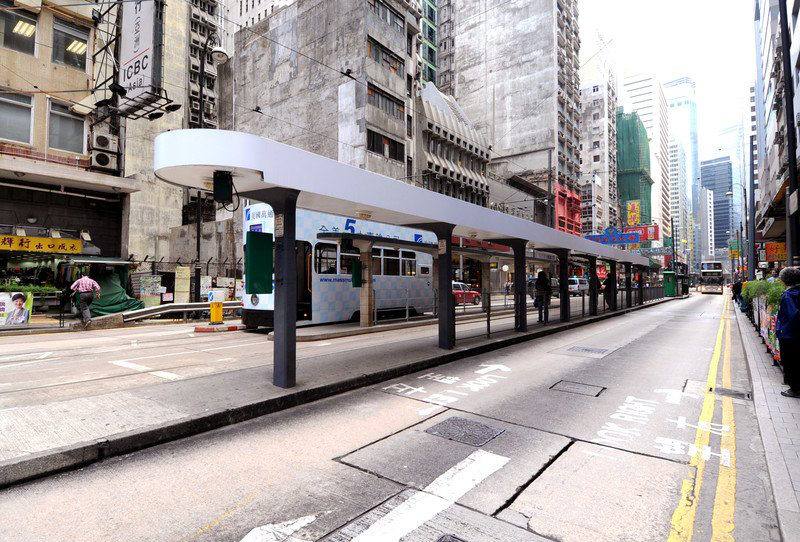

Generated caption: a tram station on the left of the tram station on the right of the tram station on the left of the tram station on the left of the tram station on the left of the tram station on the left of the tram station on the left of the tram station on the left of the tram station on the left of the tram station on
File name: dsc_4762.jpg
Time taken: 6.72


100%|████████████████████████████████████████| 1/1 [00:06<00:00,  6.49s/it]


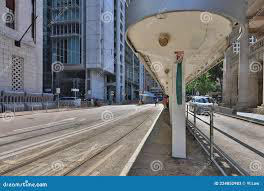

Generated caption: a street sign on a city street with a sky background                                                        
File name: images (1).jpg
Time taken: 6.59


100%|████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


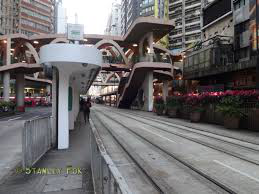

Generated caption: A train station with a train on the tracks.
File name: images (2).jpg
Time taken: 0.81


100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


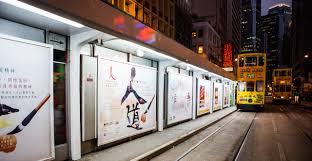

Generated caption: A city street with a bus stop and a sign for a restaurant.
File name: images (3).jpg
Time taken: 1.11


100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


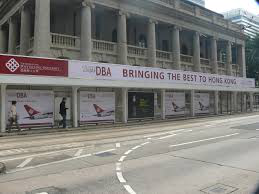

Generated caption: showroom with a lot of signs and a building with a sign on the wall.
File name: images.jpg
Time taken: 1.26
Average time taken: 3.82


In [51]:
IMAGE_FOLDER = "./object_test/tram_station"


# Get list of image file paths
image_paths = glob.glob(IMAGE_FOLDER + "/*.jpg")

time_sum = 0

# Loop over each image file path
for image_path in image_paths:
    start_time = time.time()
    # Open image using PIL
    image = io.imread(image_path)
    pil_image = PIL.Image.fromarray(image)
    image = preprocess(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        try:
            generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
        except TypeError:
            continue

    # Display image and output
    end_time = time.time()
    time_taken = round(end_time - start_time, 2)
    time_sum += time_taken


    display(pil_image)
    print("Generated caption:", generated_text_prefix)
    # Extract file name from the path
    file_name = os.path.basename(image_path)
    print("File name:", file_name)
    print("Time taken: {}".format(time_taken))


print("Average time taken:", time_sum/len(image_paths))